# Modelo de machine learning para el apoyo diagn√≥stico temprano: una soluci√≥n para la eficiencia hospitalaria y sostenibilidad del sistema de salud

Este notebook tiene como objetivo desarrollar un modelo de clasificaci√≥n para predecir diagn√≥sticos m√©dicos a partir de s√≠ntomas reportados por pacientes



In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from pycaret.classification import setup
from pycaret.classification import *
from pycaret.classification import load_model
from pycaret.classification import models

## 1. Carga del Dataset

Primero, se importa la biblioteca pandas y se carga el archivo CSV con el conjunto de datos de enfermedades y s√≠ntomas. Este dataset contiene una columna llamada diseases que representa el diagn√≥stico, y varias columnas que indican la presencia o ausencia de s√≠ntomas codificadas como One Hot Encoders

In [3]:
# Cargar el archivo
df = pd.read_csv(r"Final_Augmented_dataset_Diseases_and_Symptoms.csv")

In [4]:
df

diseases  anxiety and nervousness  depression  \
0               panic disorder                        1           0   
1               panic disorder                        0           0   
2               panic disorder                        1           1   
3               panic disorder                        1           0   
4               panic disorder                        1           1   
...                        ...                      ...         ...   
246940  open wound of the nose                        0           0   
246941  open wound of the nose                        0           0   
246942  open wound of the nose                        0           0   
246943  open wound of the nose                        0           0   
246944  open wound of the nose                        0           0   

        shortness of breath  depressive or psychotic symptoms  \
0                         1                                 1   
1                         1                                 1   
2                         1                                 1   
3                         0                                 1   
4                         0                                 0   
...                     ...                               ...   
246940                    0                                 0   
246941                    0                                 0   
246942                    0                                 0   
246943                    0                                 0   
246944                    0                                 0   

        sharp chest pain  dizziness  insomnia  abnormal involuntary movements  \
0                      0          0         0                               0   
1                      0          1         1                               0   
2                      0          1         1                               0   
3                      0          1         1                               1   
4                      0          0         1                               1   
...                  ...        ...       ...                             ...   
246940                 0          0         0                               0   
246941                 0          0         0                               0   
246942                 0          0         0                               0   
246943                 0          0         0                               0   
246944                 0          0         0                               0   

        chest tightness  ...  stuttering or stammering  problems with orgasm  \
0                     1  ...                         0                     0   
1                     0  ...                         0                     0   
2                     0  ...                         0                     0   
3                     0  ...                         0                     0   
4                     1  ...                         0                     0   
...                 ...  ...                       ...                   ...   
246940                0  ...                         0                     0   
246941                0  ...                         0                     0   
246942                0  ...                         0                     0   
246943                0  ...                         0                     0   
246944                0  ...                         0                     0   

        nose deformity  lump over jaw  sore in nose  hip weakness  \
0                    0              0             0             0   
1                    0              0             0             0   
2                    0              0             0             0   
3                    0              0             0             0   
4                    0              0             0             0   
...                ...            ...   

## 2. Exploraci√≥n Inicial: Distribuci√≥n de Diagn√≥sticos

Se realiza un conteo de la cantidad de registros disponibles para cada diagn√≥stico. Esto permite identificar si existen clases con muy pocos ejemplos, lo cual podr√≠a perjudicar el entrenamiento del modelo.

Adem√°s, se imprime:

El n√∫mero total de diagn√≥sticos √∫nicos.

La cantidad de diagn√≥sticos con solo un registro (clases demasiado escasas).

In [22]:
print(df.shape)
print("-"*150)
print("tipos de datos:")
print(df.dtypes)
print("-"*150)
print("distribuci√≥n de enfermedades:")
print(df['diseases'].value_counts())
print("-"*150)
print("valores nulos:")
print(df.isnull().sum())


(246945, 378)
------------------------------------------------------------------------------------------------------------------------------------------------------
tipos de datos:
diseases                            object
anxiety and nervousness              int64
depression                           int64
shortness of breath                  int64
depressive or psychotic symptoms     int64
                                     ...  
hip weakness                         int64
back swelling                        int64
ankle stiffness or tightness         int64
ankle weakness                       int64
neck weakness                        int64
Length: 378, dtype: object
------------------------------------------------------------------------------------------------------------------------------------------------------
distribuci√≥n de enfermedades:
cystitis                          1219
vulvodynia                        1218
nose disorder                     1218
complex regional pai

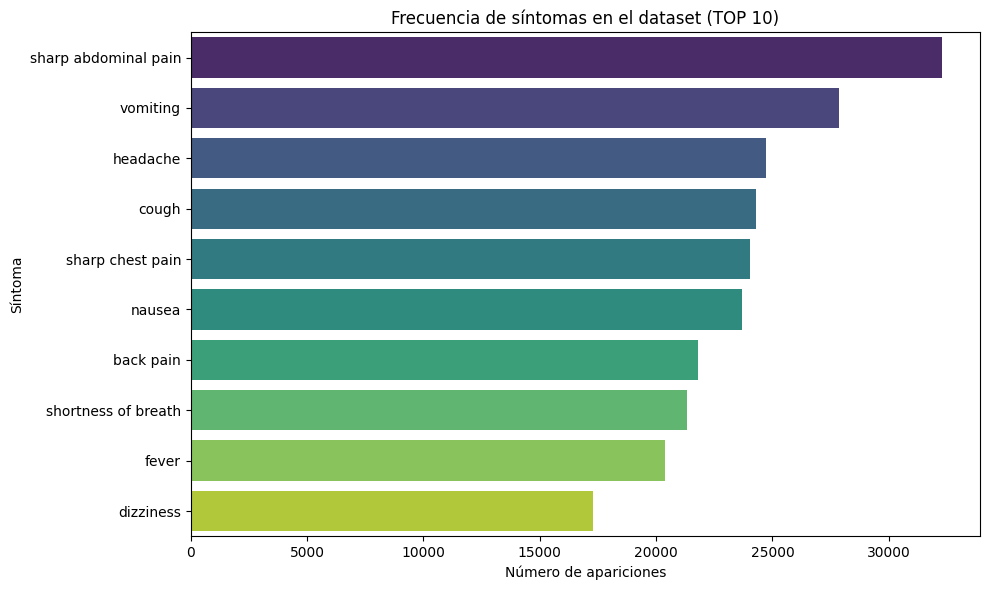

In [ ]:

symptom_counts = df.drop(columns='diseases').sum().sort_values(ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=symptom_counts.values[:10], y=symptom_counts.index[:10], palette='viridis')
plt.title('Frecuencia de s√≠ntomas en el dataset (TOP 10)')
plt.xlabel('N√∫mero de apariciones')
plt.ylabel('S√≠ntoma')
plt.tight_layout()
plt.show()


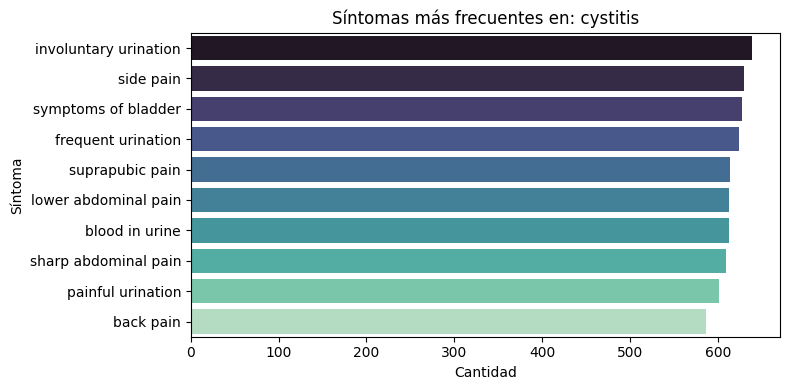

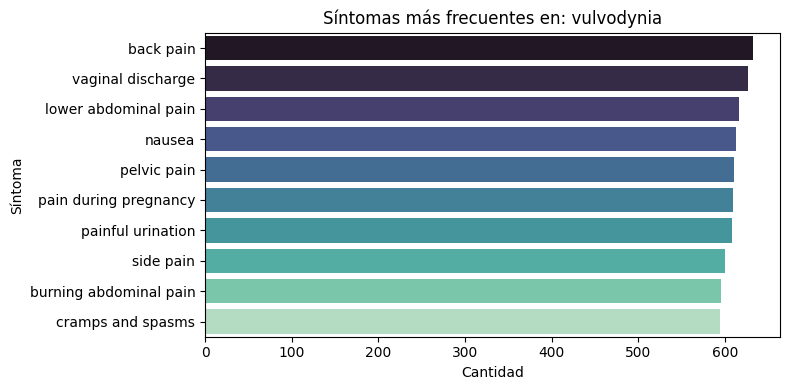

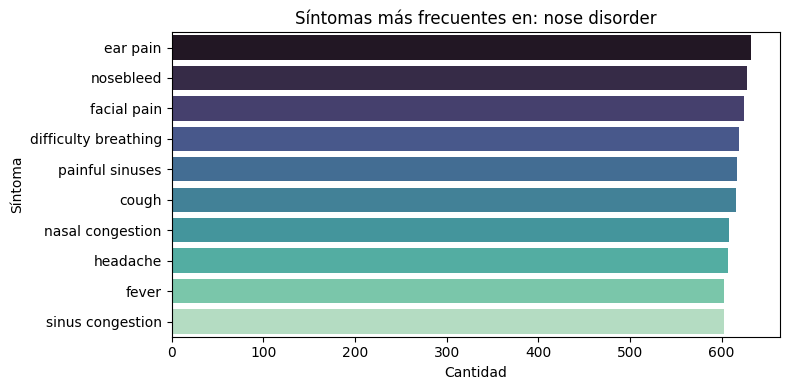

In [28]:
top_diseases = df['diseases'].value_counts().head(3).index

for disease in top_diseases:
    subset = df[df['diseases'] == disease]
    top_symptoms = subset.drop(columns='diseases').sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette='mako')
    plt.title(f'S√≠ntomas m√°s frecuentes en: {disease}')
    plt.xlabel('Cantidad')
    plt.ylabel('S√≠ntoma')
    plt.tight_layout()
    plt.show()


In [5]:
# Contar cu√°ntos registros hay por diagn√≥stico
conteo_diagnosticos = df['diseases'].value_counts()

# Ver los diagn√≥sticos que solo tienen un registro
diagnosticos_unicos = conteo_diagnosticos[conteo_diagnosticos == 1]

# Mostrar resumen
print(f"N√∫mero total de diagn√≥sticos √∫nicos: {conteo_diagnosticos.shape[0]}")
print(f"N√∫mero de diagn√≥sticos con solo un registro: {diagnosticos_unicos.shape[0]}")

N√∫mero total de diagn√≥sticos √∫nicos: 773
N√∫mero de diagn√≥sticos con solo un registro: 19


## 3. Filtrado de Diagn√≥sticos con Pocos Registros

Para asegurar una mejor calidad del modelo, se excluyen los diagn√≥sticos que tienen menos de un umbral m√≠nimo de registros (definido en 100 registros). Esto permite centrarse en las clases m√°s representativas y con una cantidad de informacion considerable al momento del entrenamiento.

Se imprime:

El n√∫mero de diagn√≥sticos que cumplen con el umbral.

El tama√±o del nuevo dataset resultante.



In [6]:
umbral = 100  # o el valor que decidas
diagnosticos_validos = df['diseases'].value_counts()
diagnosticos_filtrados = diagnosticos_validos[diagnosticos_validos >= umbral].index

df_filtrado = df[df['diseases'].isin(diagnosticos_filtrados)]
print(f"N√∫mero de diagn√≥sticos incluidos: {len(diagnosticos_filtrados)}")
print(f"Nuevo tama√±o del dataset: {df_filtrado.shape}")


N√∫mero de diagn√≥sticos incluidos: 443
Nuevo tama√±o del dataset: (236619, 378)


## 4. Visualizaci√≥n de Diagn√≥sticos Filtrados

Se crea una gr√°fica de barras que muestra la cantidad de registros por diagn√≥stico, una vez aplicado el filtrado. Esta visualizaci√≥n ayuda a entender c√≥mo est√° distribuido el nuevo dataset y qu√© diagn√≥sticos son los m√°s frecuentes y menos frecuentes

cystitis         1219
nose disorder    1218
vulvodynia       1218
Name: diseases, dtype: int64


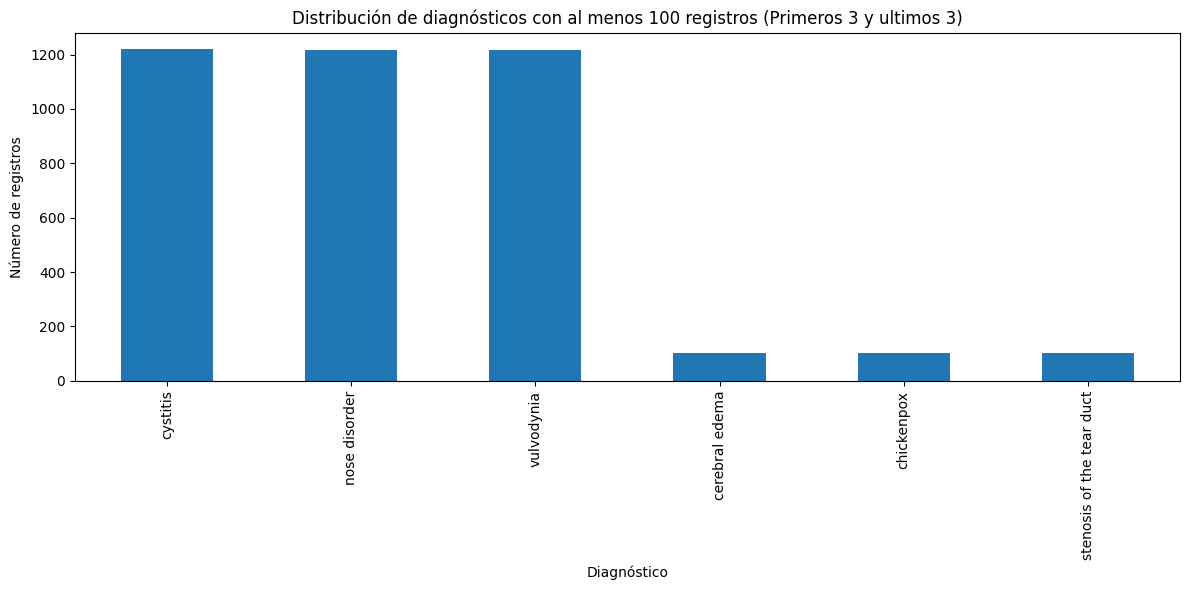

In [ ]:
import matplotlib.pyplot as plt

# Ver cu√°ntos diagn√≥sticos quedan y cu√°ntos registros tiene cada uno
conteo_filtrado = df_filtrado['diseases'].value_counts()

# Unirlos (si es una lista)
resultado = pd.concat([conteo_filtrado[:3], conteo_filtrado[-3:]])


# Mostrar un resumen de los diagn√≥sticos m√°s comunes
print(primeros_3)  # Top 10 diagn√≥sticos m√°s frecuentes

# Visualizar la distribuci√≥n
plt.figure(figsize=(12, 6))
resultado.plot(kind='bar')
plt.title('Distribuci√≥n de diagn√≥sticos con al menos 100 registros (Primeros 3 y ultimos 3)')
plt.xlabel('Diagn√≥stico')
plt.ylabel('N√∫mero de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 5. Divisi√≥n del Dataset
Se divide el conjunto de datos filtrado en un conjunto de entrenamiento (df_train) y otro de prueba (df_test), utilizando una divisi√≥n estratificada para mantener la proporci√≥n de cada clase. Esta separaci√≥n es fundamental para entrenar el modelo y luego evaluarlo con datos no vistos.

In [ ]:


df_train, df_test = train_test_split(df_filtrado, test_size=0.2, random_state=42, stratify=df_filtrado['diseases'])
#df_train.to_csv("df_train.csv")
#df_test.to_csv("df_test.csv")


## 6. Configuraci√≥n del Entorno Autom√°tico de Modelado con PyCaret
En esta secci√≥n se utiliza PyCaret, una biblioteca de c√≥digo abierto para machine learning automatizado (AutoML). PyCaret permite entrenar, comparar y optimizar modelos de clasificaci√≥n con una m√≠nima cantidad de c√≥digo, facilitando el trabajo especialmente en proyectos exploratorios o prototipos r√°pidos.

### ¬øC√≥mo funciona PyCaret?
Al ejecutar la funci√≥n setup(), PyCaret realiza autom√°ticamente:

An√°lisis de tipo de variables (num√©ricas, categ√≥ricas, booleanas, etc.).

Codificaci√≥n de variables categ√≥ricas (One-Hot Encoding o Label Encoding seg√∫n corresponda).

Imputaci√≥n de valores faltantes si es necesario.

Normalizaci√≥n o estandarizaci√≥n de variables num√©ricas.

Separaci√≥n entre variables predictoras (features) y la variable objetivo (target).

Partici√≥n del conjunto de datos en entrenamiento y validaci√≥n.

Aplicaci√≥n de validaci√≥n cruzada (cross-validation) de forma predeterminada, t√≠picamente con 10 particiones (K-Fold CV) para garantizar estimaciones m√°s robustas del desempe√±o del modelo.

### ¬øPor qu√© es confiable?
PyCaret implementa buenas pr√°cticas de machine learning por defecto:

Eval√∫a todos los modelos bajo un esquema de validaci√≥n cruzada, reduciendo el riesgo de sobreajuste.

Calcula m√∫ltiples m√©tricas de evaluaci√≥n (Accuracy, Precision, Recall, F1-Score, AUC).

Establece una session_id para asegurar reproducibilidad.

Permite integrar t√©cnicas avanzadas como ajuste de hiperpar√°metros, selecci√≥n autom√°tica de caracter√≠sticas, interpretabilidad del modelo (SHAP), entre otros.

Con el entorno configurado en PyCaret, se utiliza la funci√≥n compare_models() para evaluar varios modelos de clasificaci√≥n. En este caso, se comparan algoritmos espec√≠ficos como:

Regresi√≥n log√≠stica (lr)

Vecinos m√°s cercanos (knn)

Naive Bayes (nb)

√Årboles de decisi√≥n (dt)

An√°lisis discriminante cuadr√°tico (qda)

An√°lisis discriminante lineal (lda)

Regresi√≥n Ridge (ridge)

Extra Trees (et)

PyCaret eval√∫a autom√°ticamente estos modelos utilizando m√©tricas como precisi√≥n, F1-score, AUC, etc., y selecciona los mejores en funci√≥n del desempe√±o.




In [ ]:


# Paso 1: Configurar PyCaret (usa df_train y la columna 'diseases' como objetivo)
clf_setup = setup(
    data=df_train,
    target='diseases',
    session_id=42,
    test_data=df_test  # Esto permite evaluar en conjunto de prueba
)

top_modelos= compare_models(include=["lr","knn","nb","dt","qda","lda","ridge","et"],n_select=5)


c:\Users\Juan Pablo Bertel M\Desktop\Proyecto_integrador_2\venv\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:339: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_cols, subset=["TT (Sec)"])


AttributeError: 'LogisticRegression' object has no attribute '_class_'

## 8. Guardado de Modelos Iniciales

Despu√©s de seleccionar los mejores modelos, cada uno se guarda en disco utilizando save_model(). Esto permite reutilizar los modelos posteriormente sin necesidad de volver a entrenarlos desde cero.

In [20]:
# Guardar los modelos
for modelo in top_modelos:
    nombre_modelo = modelo.__class__.__name__
    save_model(modelo, f"modelo_{nombre_modelo}")

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


## 9. Optimizaci√≥n de Modelos (Tuning)
Se aplica un proceso de ajuste de hiperpar√°metros (tune_model()) sobre cada modelo previamente seleccionado, optimizando la m√©trica F1. Esta etapa busca mejorar el desempe√±o de cada clasificador mediante una b√∫squeda simple en el espacio de hiperpar√°metros.

Cada modelo optimizado tambi√©n se guarda con un nombre distinto.

In [ ]:

clf_setup = setup(
    data=df_train,
    target='diseases',
    session_id=42,
    test_data=df_test,
    n_jobs=-1,
    fold=5
)


In [ ]:

modelo = load_model("modelo_DecisionTreeClassifier")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_De{nombre_modelo}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('trained_mo

In [19]:
modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_De{nombre_modelo}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('trained_model',
                  DecisionTreeClassifier(ccp_alpha=0.0, cla

In [12]:
modelo = load_model("modelo_KNeighborsClassifier")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_KNN{nombre_modelo}")


Transformation Pipeline and Model Successfully Loaded


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                        

In [13]:
modelo = load_model("modelo_GaussianNB")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_GaussianNB{nombre_modelo}")


Transformation Pipeline and Model Successfully Loaded


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                       

In [15]:
modelo = load_model("modelo_GaussianNB")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=10, n_iter=20)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_GaussianNB{nombre_modelo}")

Transformation Pipeline and Model Successfully Loaded


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                       

In [14]:
modelo = load_model("modelo_QuadraticDiscriminantAnalysis")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_modelo_QuadraticDiscriminantAnalysis{nombre_modelo}")


Transformation Pipeline and Model Successfully Loaded


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                                               copy=True,
                                                               fill_value=None,
                                           

## 10. Evaluaci√≥n del Modelo y Matriz de Confusi√≥n
Para evaluar el rendimiento de los modelos seleccionados y afinados, se realiza una predicci√≥n sobre el conjunto de prueba (df_test). A partir de esto, se comparan las etiquetas verdaderas (y_true) con las etiquetas predichas (y_pred).

Se construye una matriz de confusi√≥n usando √∫nicamente las 10 clases (diagn√≥sticos) m√°s frecuentes, lo que permite visualizar de forma clara qu√© tan bien clasifica el modelo en las clases m√°s representativas.

In [ ]:
#evaluaciones
modelo = load_model("modelo_QuadraticDiscriminantAnalysis")

Transformation Pipeline and Model Successfully Loaded


In [18]:
print(modelo)

Pipeline(memory=FastMemory(location=C:\Users\JUANPA~1\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['anxiety and nervousness',
                                             'depression',
                                             'shortness of breath',
                                             'depressive or psychotic symptoms',
                                             'sharp ch...
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              mi

In [ ]:
#modelo = load_model("modelo_QuadraticDiscriminantAnalysis")
evaluate_model(modelo)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin‚Ä¶

<Figure size 800x550 with 0 Axes>

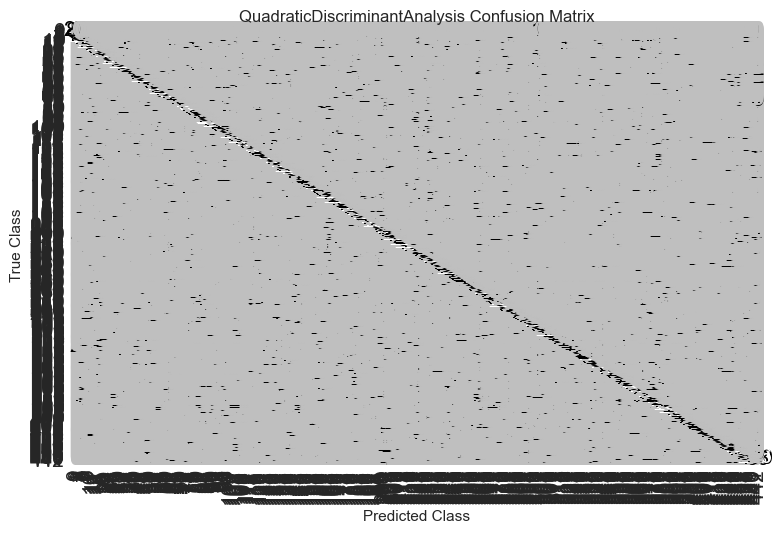

In [22]:
plot_model(modelo, plot='confusion_matrix')

In [26]:
from pycaret.classification import predict_model

# Obtener predicciones sobre el test set
df_pred = predict_model(modelo, data=df_test)

In [27]:
df_pred["prediction_score"].value_counts()

prediction_score
1.0000    45471
0.9999      177
0.9998       73
0.9997       65
0.9994       41
          ...  
0.7188        1
0.9839        1
0.7081        1
0.9463        1
0.8279        1
Name: count, Length: 718, dtype: int64

## 11. Evaluaci√≥n de Todos los Modelos Afinados
El notebook carga cada modelo previamente afinado y guardado, aplicando las siguientes acciones:

Carga del modelo.

Predicci√≥n sobre el conjunto de prueba.

Selecci√≥n de las 10 clases m√°s frecuentes.

Construcci√≥n y visualizaci√≥n de la matriz de confusi√≥n.

Guardado autom√°tico de la gr√°fica en formato PNG.

Esto permite comparar visualmente el desempe√±o de cada modelo de forma automatizada.

In [31]:
# Variables reales y predichas
y_true = df_test['diseases']
y_pred = df_pred['prediction_label']

In [32]:
from collections import Counter
import numpy as np

# Obtener las 10 clases m√°s frecuentes
top_classes = [label for label, _ in Counter(y_true).most_common(10)]

# Filtrar para mostrar solo esas clases
mask = y_true.isin(top_classes)
y_true_top = y_true[mask]
y_pred_top = y_pred[mask]


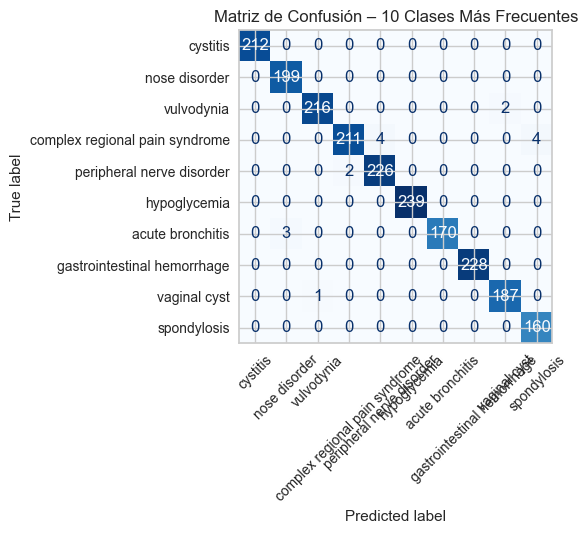

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_top, y_pred_top, labels=top_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
disp.plot(xticks_rotation=45, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusi√≥n ‚Äì 10 Clases M√°s Frecuentes")
plt.tight_layout()
plt.show()


üìä Procesando modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline...
Transformation Pipeline and Model Successfully Loaded


‚ö†Ô∏è Error con modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline_confusion.png'
üìä Procesando modelo_tuneado_logistic...
Transformation Pipeline and Model Successfully Loaded


‚ö†Ô∏è Error con modelo_tuneado_logistic: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_logistic_confusion.png'
üìä Procesando modelo_tuneado_KNNPipeline...
Transformation Pipeline and Model Successfully Loaded


‚ö†Ô∏è Error con modelo_tuneado_KNNPipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_KNNPipeline_confusion.png'
üìä Procesando modelo_tuneado_GaussianNBPipeline...
Transformation Pipeline and Model Successfully Loaded


‚ö†Ô∏è Error con modelo_tuneado_GaussianNBPipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_GaussianNBPipeline_confusion.png'
üìä Procesando modelo_tuneado_DePipeline...
Transformation Pipeline and Model Successfully Loaded


‚ö†Ô∏è Error con modelo_tuneado_DePipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_DePipeline_confusion.png'


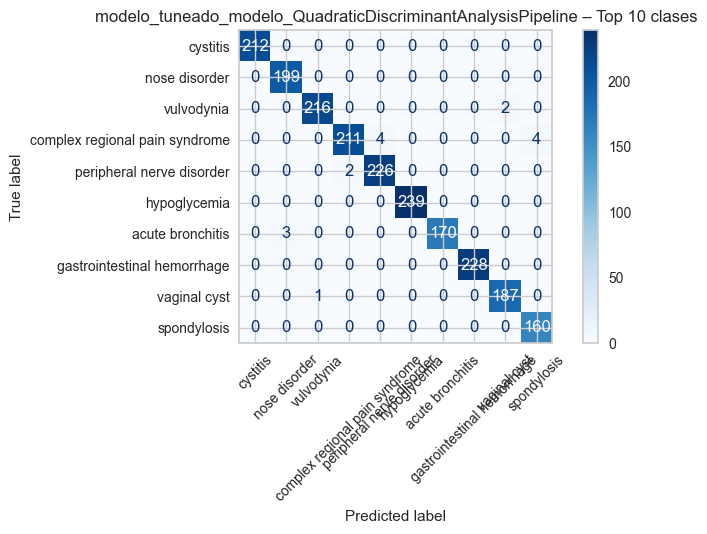

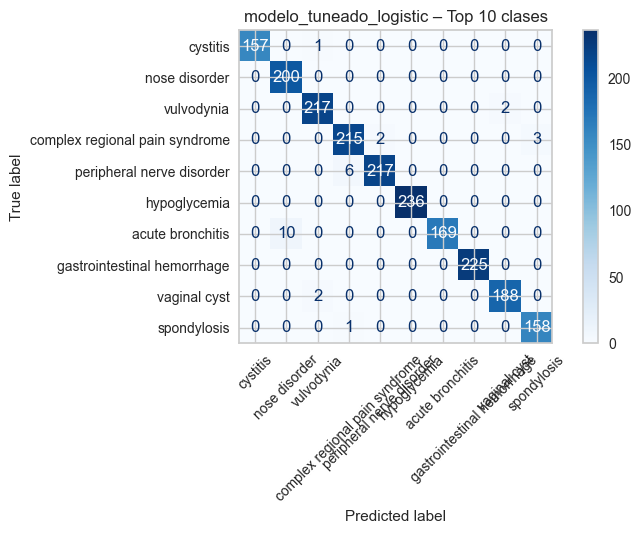

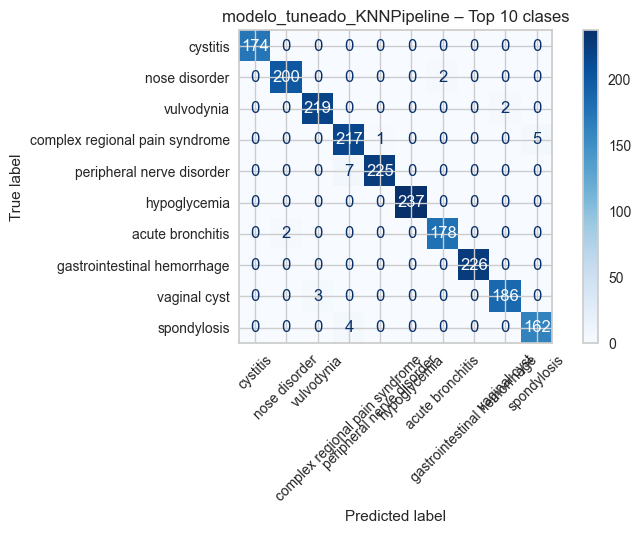

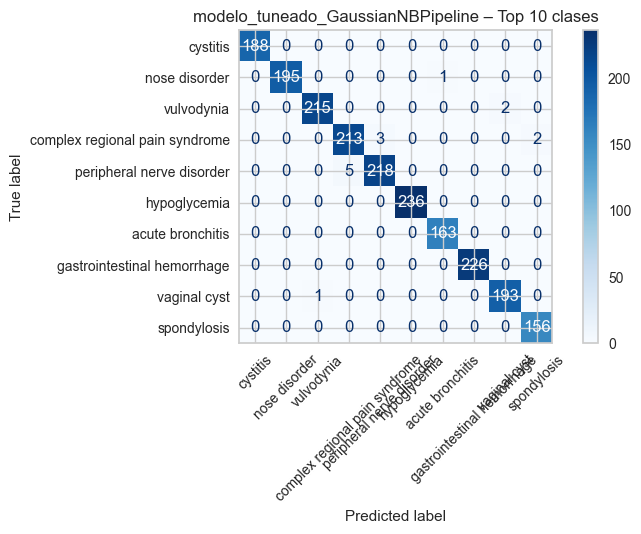

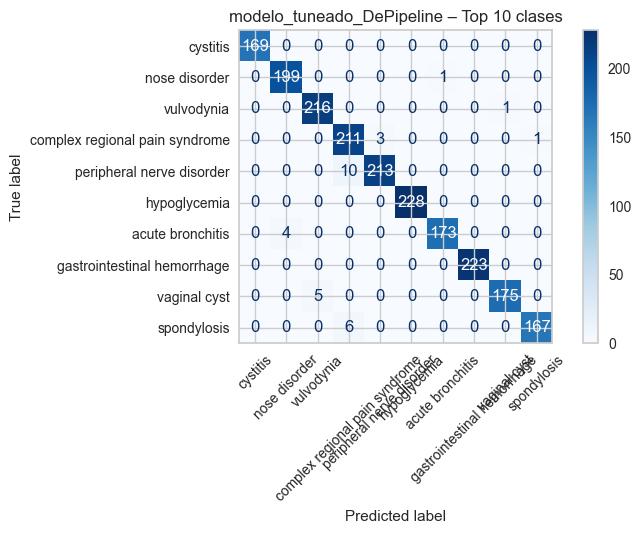

In [35]:
# Cargar todos los modelos .pkl en esa carpeta
modelos = ["modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline","modelo_tuneado_logistic","modelo_tuneado_KNNPipeline","modelo_tuneado_GaussianNBPipeline","modelo_tuneado_DePipeline"]

for archivo in modelos:
    try:
        nombre_modelo = archivo.replace('.pkl', '')
        print(f"üìä Procesando {nombre_modelo}...")

        # 1. Cargar modelo
        modelo = load_model(nombre_modelo)

        # 2. Predecir sobre df_test
        df_pred = predict_model(modelo, data=df_test)

        # 3. Extraer etiquetas reales y predichas
        y_true = df_pred['diseases']
        y_pred = df_pred['prediction_label']

        # 4. Seleccionar 10 clases m√°s frecuentes
        top_classes = [label for label, _ in Counter(y_true).most_common(10)]
        mask = y_true.isin(top_classes)
        y_true_top = y_true[mask]
        y_pred_top = y_pred[mask]

        # 5. Crear y guardar matriz
        cm = confusion_matrix(y_true_top, y_pred_top, labels=top_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title(f"{nombre_modelo} ‚Äì Top 10 clases")
        plt.tight_layout()
        plt.savefig(f"matrices_confusion/{nombre_modelo}_confusion.png", dpi=300)
        plt.close()

    except Exception as e:
        print(f"‚ö†Ô∏è Error con {archivo}: {e}")

## 12. Limpieza del Modelo para Producci√≥n
Finalmente, una vez convencidos del rendimiento de los modelos, se carga un modelo espec√≠fico (en este caso, un modelo de tipo XGBoost) y se eliminan atributos innecesarios relacionados con visualizaci√≥n, registro y seguimiento de experimentos, con el fin de aligerar el modelo antes de su uso en producci√≥n.

Esta limpieza reduce el tama√±o del objeto serializado y evita errores al integrarlo en una API o sistema externo, ademas de poder cumplir con las limitaciones de memoria de 25 MB para archivos PKL que tiene GitHub



In [89]:
modelo = load_model("modelo_xgboost_gpu_model")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
# Limpiar campos pesados que no necesitas en producci√≥n
modelo._display_container = None
modelo._setup = None
modelo._logger = None
modelo._plots = None


AttributeError: 'XGBClassifier' object has no attribute 'pipeline'

In [90]:
# Aseg√∫rate de que ya hiciste setup()
modelo._display_container = None
modelo._setup = None
modelo._logger = None
modelo._plots = None
modelo._ml_usecase = None
modelo._is_multiclass = None
modelo._is_binary = None
modelo._mlflow = None
modelo._pipeline_custom = None
modelo._raise_warnings = None
modelo._gpu_n_jobs_param = None
modelo._shap = None
modelo._is_unsupervised = None

# Eliminar atributos relacionados a experiment tracking
if hasattr(modelo, '_wandb_setup'):
    modelo._wandb_setup = None

if hasattr(modelo, '_mlflow_setup'):
    modelo._mlflow_setup = None

# Limpiar posibles artefactos del plot_model
if hasattr(modelo, '_plot_model_results'):
    modelo._plot_model_results = None



In [92]:
modelo._Booster = modelo.get_booster()

modelo.set_params(n_jobs=1)  # eliminar atributos temporales
 

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None,
              custom_pipeline_parameters={'tree_method': 'gpu_hist'},
              device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=1, ...)

In [93]:
save_model(modelo, f"modelo_xgboost_gpu_model_depurado_4")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\JUANPA~1\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp ch...
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                      

In [94]:
import joblib

modelo = load_model("modelo_xgboost_gpu_model_depurado_4")

# Guardar modelo con compresi√≥n
joblib.dump(modelo, 'modelo_xgboost_gpu_model_depurado_4_gz.pkl.gz', compress=9)  # compresi√≥n 0‚Äì9

Transformation Pipeline and Model Successfully Loaded


['modelo_xgboost_gpu_model_depurado_4_gz.pkl.gz']

In [96]:
import lzma
import pickle

with lzma.open('modelo_xgboost_gpu_model_depurado_4.pkl.xz', 'wb', preset=9) as f:
    pickle.dump(modelo, f)

## Conclusiones
Este proyecto demostr√≥ c√≥mo es posible construir un modelo de clasificaci√≥n autom√°tica capaz de predecir diagn√≥sticos m√©dicos a partir de s√≠ntomas reportados. Entre los principales hallazgos se destacan:

Filtrado efectivo: Al eliminar diagn√≥sticos con pocos registros, se mejor√≥ el balance de clases y la calidad del entrenamiento.

Automatizaci√≥n del proceso: PyCaret permiti√≥ comparar, ajustar y guardar m√∫ltiples modelos con gran facilidad, reduciendo significativamente el esfuerzo manual y teniendo la seguridad de implentar metricas de validacion, como validacion cruzada usada dentre de la misma libreria de pycaret

Visualizaci√≥n clara del desempe√±o: El uso de matrices de confusi√≥n centradas en las clases m√°s frecuentes facilit√≥ la interpretaci√≥n de los errores m√°s comunes de los modelos.

Preparaci√≥n para producci√≥n: Se limpi√≥ un modelo final para su integraci√≥n en entornos reales, minimizando dependencias y optimizando su portabilidad.

## Anexos

Se anexa codigo que se corrio en google colab para aprovechar el entorno de ejecucion y la posibilidad de usar GPU debido a la complejidad de los modelos Xgboost y lightGBM

NOTA: No se recomieda correr esta parte del codigo

In [ ]:
# !pip install --quiet --upgrade scikit-learn==1.2.2 pycaret[full] xgboost catboost lightgbm

In [ ]:
# clf_setup = setup(
#     data=df_train,
#     target='diseases',
#     session_id=42,
#     test_data=df_test,
#     use_gpu=True  # Activar uso de GPU en modelos compatibles
# )


# # Comparar solo modelos compatibles con GPU
# best_model = compare_models(include=['xgboost', 'catboost'])

In [ ]:

# # Paso 2: Entrenar modelos GPU por separado
# xgb_gpu = create_model('xgboost', fold=5, custom_pipeline_parameters={
#     'tree_method': 'gpu_hist'  # activa GPU en XGBoost
# })

# # Guardar el modelo como archivo .pkl
# save_model(xgb_gpu, 'xgboost_gpu_model')

# cat_gpu = create_model('catboost', fold=5, custom_pipeline_parameters={
#     'task_type': 'GPU'  # activa GPU en CatBoost
# })

# # Guardar el modelo como archivo .pkl
# save_model(cat_gpu, 'cayboost_gpu_model')

# # Crear modelo LightGBM con GPU
# lgb_gpu = create_model('lightgbm', fold=5)

# # Guardar modelo
# save_model(lgb_gpu, 'modelo_lightgbm_gpu')

In [ ]:
# xgb_tuned = tune_model(
#     xgb_gpu,
#     optimize='F1',     # o 'Accuracy', 'AUC', etc., seg√∫n tu objetivo
#     choose_better=True,
#     fold=5,
#     verbose=True
# )
